In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('input/train.csv')

### train_test_split 

In [3]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)

In [4]:
train.shape, valid.shape

((7000, 20), (3000, 20))

### prepare data

In [5]:
def prepare_rooms(df, source_df):
    df.loc[df['Rooms'] > 5, 'Rooms'] = source_df['Rooms'].median()
    return df

In [6]:
train = prepare_rooms(train, train)

In [7]:
stats1 = train.groupby(['DistrictId', 'Rooms'], as_index=False)[['Price']].mean().rename(columns={'Price':'mean_price'})
stats1

,DistrictId,Rooms,mean_price
0,0,1.0,145789.889600
1,0,2.0,198451.332808
2,0,3.0,291670.749162
3,1,1.0,147116.367405
4,1,2.0,198151.757027
5,1,3.0,247145.388423
6,1,4.0,277290.705058
7,2,1.0,184560.609064
8,2,2.0,247244.824542
9,2,3.0,338384.676484


In [8]:
def join_stats1(df, stats1, source_df, mode='train'):
    df = pd.merge(df, stats1, on=['DistrictId', 'Rooms'], how='left')
    if mode == 'test':
        df['mean_price'] = df['mean_price'].fillna(source_df['mean_price'].mean())
    return df

In [9]:
def fillna_life_square(df, source_df):
    df['LifeSquare'] = df['LifeSquare'].fillna(source_df['LifeSquare'].mean())
    return df

In [10]:
train = join_stats1(train, stats1, train)
train = fillna_life_square(train, train)

In [11]:
valid = prepare_rooms(valid, train)
valid = join_stats1(valid, stats1, train, mode='test')
valid = fillna_life_square(valid, train)

### Model

In [12]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF

In [41]:
?RF

In [42]:
model = RF(n_estimators=100, max_depth=11, min_samples_leaf=2)

In [43]:
feats = ['Square', 'Rooms', 'mean_price', 'LifeSquare']

In [44]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [45]:
pred_train = model.predict(train.loc[:, feats])

In [46]:
pred_valid = model.predict(valid.loc[:, feats])

In [47]:
pred_train.shape, pred_valid.shape

((7000,), (3000,))

### Evaluation

In [48]:
from sklearn.metrics import r2_score as r2, mean_squared_error as mse

In [49]:
r2(train['Price'], pred_train), mse(train['Price'], pred_train)

(0.8733611966171939, 1093372157.5231996)

In [50]:
r2(valid['Price'], pred_valid), mse(valid['Price'], pred_valid)

(0.6236743660002699, 3237060904.058522)

### Test

In [51]:
test = pd.read_csv('input/test.csv')

In [52]:
test.shape

(5000, 19)

In [53]:
test = prepare_rooms(test, train)
test = join_stats1(test, stats1, train, mode='test')
test = fillna_life_square(test, train)

In [54]:
test['Price'] = model.predict(test.loc[:, feats])

In [55]:
test['Price'].describe()

count      5000.000000
mean     212911.719753
std       76593.041920
min       67650.529650
25%      165560.896665
50%      196340.345577
75%      244671.446391
max      573408.779722
Name: Price, dtype: float64

In [56]:
test.loc[:, ['Id', 'Price']].to_csv('SShirkin_predictions.csv', index=None)

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

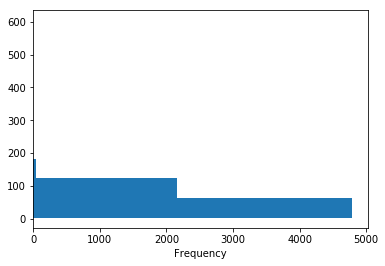

In [66]:
train['Square'].plot(kind='hist', orientation='horizontal')

In [64]:
?plt.hist